# Time Causal VAE

In [2]:
%load_ext autoreload
%autoreload 2
import sys
import yaml
sys.path.append('../src')
sys.path.append('../../../..')
from tsvae.utils.logger_utils import get_console_logger
logger = get_console_logger(__name__)
from os import path as pt
from data_processing.post_processing import post_processing
from data_processing.config import post_processing_config
from models.DeepHedger import hedging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data used in original paper

(2516, 2)


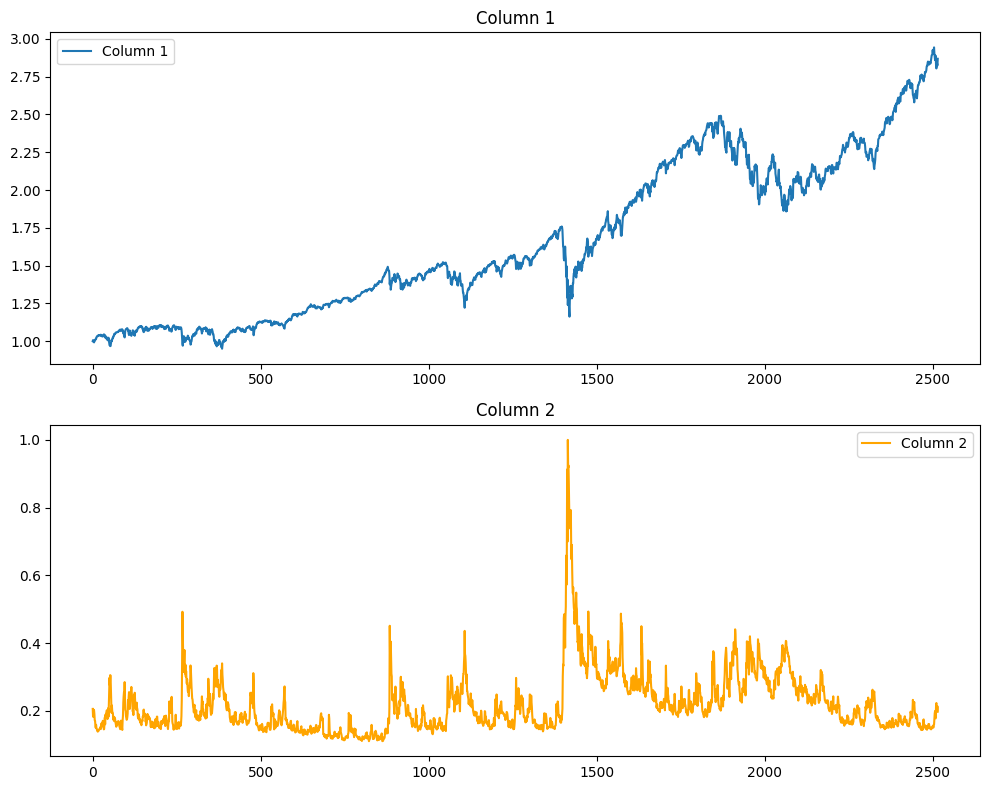

In [3]:
import numpy as np
import matplotlib.pyplot as plt

data = np.load("../data/sp500vix/sp500vix_normalized.npy")
print(data.shape)
fig, axs = plt.subplots(2, 1, figsize=(10, 8))

axs[0].plot(data[:, 0], label="Column 1")
axs[0].set_title("Column 1")
axs[0].legend()

axs[1].plot(data[:, 1], label="Column 2", color="orange")
axs[1].set_title("Column 2")
axs[1].legend()

plt.tight_layout()
plt.show()


## Create Data for Master Thesis

In [30]:
import numpy as np
import pandas as pd

df = pd.read_csv("../../../../../data/raw/spy_daily_closing_prices.csv", index_col = 0)
# df["vol"] = df["Close"].rolling(window=30).std()
# df = df.dropna()
price_scaler = data[0, 0]
vol_scaler = np.max(data[:, 1])
data = df.to_numpy()
data[:, 0] = data[:, 0]/price_scaler
data[:, 1] = data[:, 1]/vol_scaler
print(data.shape)
np.save("../data/sp500vix/sp500_normalized.npy", data)



(1089, 2)


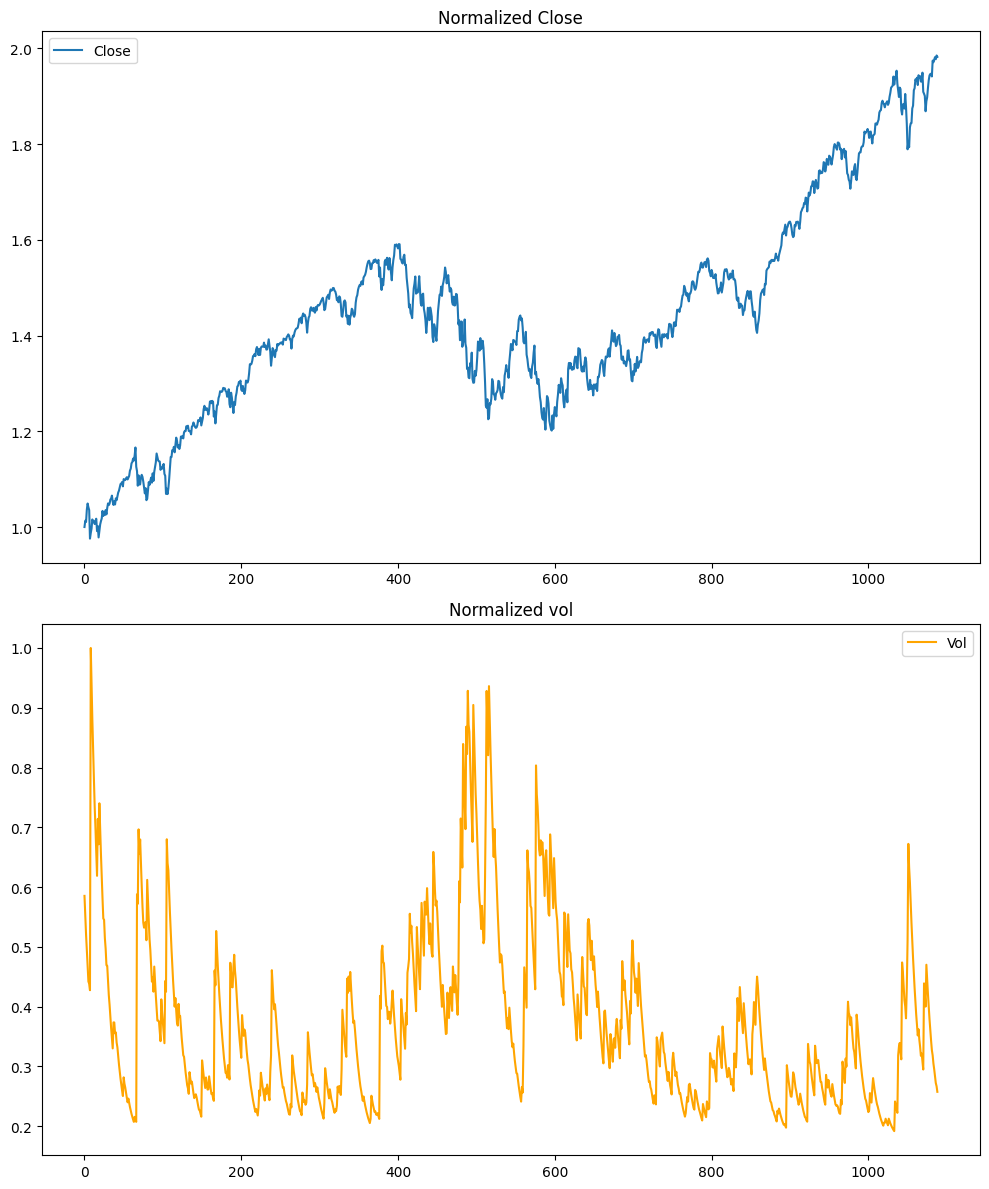

In [31]:
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

axs[0].plot(data[:, 0], label="Close")
axs[0].set_title("Normalized Close")
axs[0].legend()

axs[1].plot(data[:, 1], label="Vol", color="orange")
axs[1].set_title("Normalized vol")
axs[1].legend()

# axs[2].plot(rolling_volatility, label="30-Day Rolling Volatility", color="green")
# axs[2].set_title("30-Day Rolling Volatility of Column 1")
# axs[2].legend()

plt.tight_layout()
plt.show()

## TCVAE Model

In [3]:
from experiments.experiment_utils import get_output_dir, update_config
from tsvae.dataset.data_pipeline import DataPipeline
from tsvae.models.network_pipeline import NetworkPipeline
from tsvae.utils.random_utils import set_seed


base_output_dir = '..' 
new_config = {'epochs' : 100, 'wandb': False, 'comment': 'test'}
exp_config_path = '../configs/Master/betacvae.yaml'

with open(exp_config_path) as file:
    exp_config = dict(yaml.safe_load(file))

exp_config = update_config(exp_config, new_config)

exp_config.base_output_dir = base_output_dir
exp_config.output_dir = get_output_dir(exp_config)
logger.info(f"Experiment results saved to {exp_config.output_dir}")

logger.info(f"Saving experiment config to {exp_config.output_dir}")
config_file_path = pt.join(exp_config.output_dir, "exp_config.yaml")
with open(config_file_path, "w") as outfile:
    yaml.dump(exp_config, outfile, default_flow_style=False)
# logger.info(exp_config)

# Generating data
logger.info(f"Setting ramdom seed: {exp_config.seed}")
set_seed(exp_config.seed)

Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Experiment results saved to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Saving experiment config to ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test
Setting ramdom seed: 0
Setting ramdom seed: 0


In [4]:
logger.info(f"Loading dataset: {exp_config.dataset}")
data_pipeline = DataPipeline()
train_dataset, eval_dataset = data_pipeline(exp_config)

# Loading network
logger.info("Load networks:")
network_pipeline = NetworkPipeline()
model = network_pipeline(exp_config)
# logger.info(f"{model}")

Loading dataset: Master
Loading dataset: Master
Base dataset initialized
Load networks:
Load networks:


In [6]:
from tsvae.trainers.base_trainer_config import BaseTrainerConfig
from tsvae.trainers.training_pipeline import TrainingPipeline


training_config = BaseTrainerConfig(
    output_dir=exp_config.output_dir,
    learning_rate=exp_config.lr,
    per_device_train_batch_size=exp_config.train_batch_size,
    per_device_eval_batch_size=exp_config.eval_batch_size,
    optimizer_cls=exp_config.optimizer,
    optimizer_params=None,
    scheduler_cls=None,
    scheduler_params=None,
    steps_saving=exp_config.steps_saving,
    steps_predict=exp_config.steps_predict,
    seed=exp_config.seed,
    num_epochs=exp_config.epochs,
    wandb_callback=exp_config.wandb,
    wandb_output_dir=exp_config.base_output_dir + "/wandb",
)

train_pipeline = TrainingPipeline(model=model, training_config=training_config, exp_config=exp_config)

trainer = train_pipeline(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    device_name=exp_config.device_name,
)

Path Visualization of data
Model passed sanity check !
Ready for training.



In [9]:
train_pipeline.train(log_output=True)

Created ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test/BetaCVAE_training_2025-03-24_14-46-11. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: 30
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Scheduler: None
Device: cpu

Successfully launched training !

Training of epoch 1/100:  40%|████      | 2/5 [00:00<00:00, 15.95batch/s]total loss: 4.17
recon: 3.82
reg: 8.66
Eval of epoch 1/100:  20%|██        | 1/5 [00:00<00:00,  7.67batch/s]
--------------------------------------------------------------------------
Train loss: 7.2851
------------------------------------------------------------------

In [8]:
from evaluations.hyperparameter import ModelEvaluator
from os import path as pt

model_dir = pt.join(trainer.training_dir, 'final_model')
model_evaluator = ModelEvaluator(model_dir)
output_dir = model_evaluator.hyper_model_dir
model = model_evaluator.model

df_tot_fake = pd.DataFrame()
for i in range(10):
    test_data, gen_data, recon_data = model_evaluator.load_data(seed = i, n_sample_test=1000)
    ds = model_evaluator.data_ppl.base_dataset

    real_data = test_data
    recon_data = recon_data
    fake_data = gen_data

    df_sub_fake = pd.DataFrame(gen_data.detach().squeeze(-1).numpy())
    df_tot_fake = pd.concat([df_tot_fake, df_sub_fake], axis=0)


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", lin

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", lin

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", lin

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/sondrerogde/Dev/master-thesis/.venv/lib/python3.12/site-packages/ipykernel/kernelapp.py", lin

AttributeError: _UFUNC_API not found

NameError: name 'pd' is not defined

## Real Data (l) and Fake Data (r)

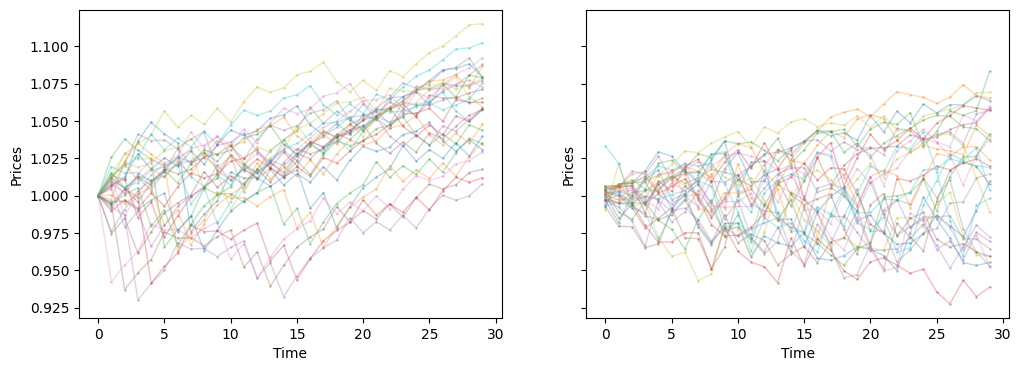

In [33]:
from evaluations.compare import compare_path
compare_path(real_data,fake_data, plot_size=30)

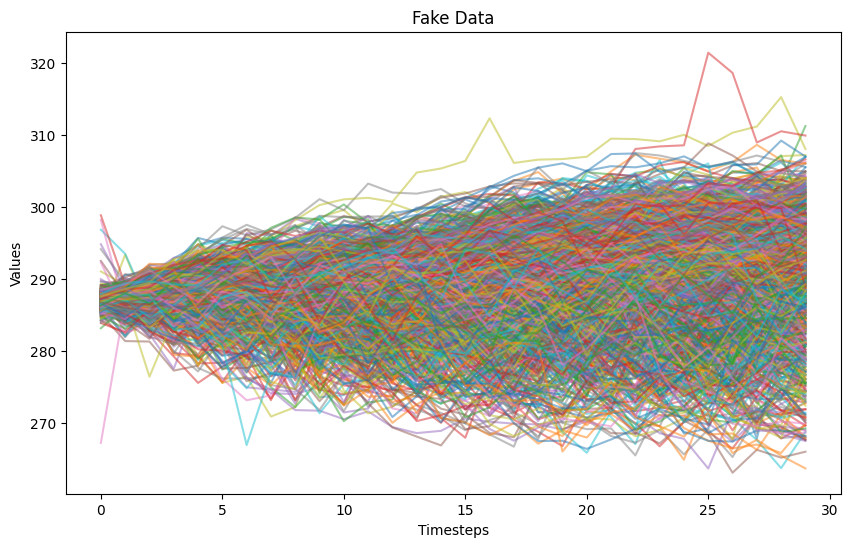

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))

# Assuming fake_data is a 3D tensor with shape (samples, timesteps, features)
for i in range(fake_data.shape[0]):  # Iterate over samples
    ax.plot(fake_data[i, :, 0].numpy()*price_scaler, alpha=0.5)  # Plot each sample

ax.set_title("Fake Data")
ax.set_xlabel("Timesteps")
ax.set_ylabel("Values")
plt.show()

In [48]:
print(fake_data.squeeze(-1))

tensor([[1.0035, 1.0055, 1.0068,  ..., 0.9552, 0.9532, 0.9553],
        [1.0002, 0.9972, 0.9985,  ..., 1.0273, 1.0472, 1.0400],
        [0.9968, 1.0004, 0.9936,  ..., 1.0459, 1.0448, 1.0369],
        ...,
        [1.0011, 1.0082, 1.0146,  ..., 1.0369, 1.0305, 1.0337],
        [1.0009, 1.0046, 1.0077,  ..., 1.0234, 1.0082, 1.0135],
        [1.0022, 1.0076, 1.0084,  ..., 1.0242, 1.0301, 1.0240]])


In [51]:
print(fake_data.squeeze(-1))

tensor([[1.0035, 1.0055, 1.0068,  ..., 0.9552, 0.9532, 0.9553],
        [1.0002, 0.9972, 0.9985,  ..., 1.0273, 1.0472, 1.0400],
        [0.9968, 1.0004, 0.9936,  ..., 1.0459, 1.0448, 1.0369],
        ...,
        [1.0011, 1.0082, 1.0146,  ..., 1.0369, 1.0305, 1.0337],
        [1.0009, 1.0046, 1.0077,  ..., 1.0234, 1.0082, 1.0135],
        [1.0022, 1.0076, 1.0084,  ..., 1.0242, 1.0301, 1.0240]])


In [10]:
import pandas as pd

In [ ]:
# Train TCVAE
train_pipeline = TrainingPipeline(model=model, training_config=training_config, exp_config=exp_config)

trainer = train_pipeline(
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    device_name=exp_config.device_name,
)

train_pipeline.train(log_output=True)

# Generate data

model_dir = pt.join(trainer.training_dir, 'final_model')
model_evaluator = ModelEvaluator(model_dir)
output_dir = model_evaluator.hyper_model_dir
model = model_evaluator.model

df_tot_fake = pd.DataFrame()
# 100 times 1000 corresponds to M = 100.000
for i in range(100):
    test_data, gen_data, recon_data = model_evaluator.load_data(seed = i, n_sample_test=1000)
    ds = model_evaluator.data_ppl.base_dataset

    real_data = test_data
    recon_data = recon_data
    fake_data = gen_data

    df_sub_fake = pd.DataFrame(gen_data.detach().squeeze(-1).numpy())
    df_tot_fake = pd.concat([df_tot_fake, df_sub_fake], axis=0)

# Post-processing
df_post_processed = post_processing(df_tot_fake, **post_processing_config)

# Hedging
val_loss = hedging(df_post_processed)

Path Visualization of data
Model passed sanity check !
Ready for training.

Created ../results/Master_timestep_30/model_BetaCVAE_De_CLSTMRes_En_CLSTMRes_Prior_RealNVP_Con_Id_Dis_None_comment_test/BetaCVAE_training_2025-03-24_16-43-19. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 256
 - per_device_eval_batch_size: 256
 - checkpoint saving every: 30
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)
Scheduler: None
Device: cpu

Successfully launched training !

Training of epoch 1/100:  40%|████      | 2/5 [00:00<00:00, 19.16batch/s]total loss: 0.67
recon: 0.57
reg: 2.35
Eval of epoch 1/100:  20%|██        | 1/5 [00:00<00:00,  7.79batch/s]
--------------------------------------------------------------------------
Train los

           1         2         3         4         5         6         7   \
0    0.006017  0.008753  0.004353  0.008667  0.001892 -0.008925 -0.014769   
1    0.003283  0.007610 -0.001784  0.002157 -0.004014 -0.007642 -0.019426   
2    0.009665 -0.003483 -0.011063 -0.018663 -0.018146  0.021757  0.006514   
3    0.002938  0.001260 -0.016104 -0.012039  0.020109  0.003311  0.014366   
4   -0.003864  0.000186  0.001981 -0.024317  0.004732  0.013348  0.018364   
..        ...       ...       ...       ...       ...       ...       ...   
995  0.003726 -0.003502 -0.001310  0.001446 -0.025039  0.018959  0.009500   
996  0.003181 -0.000687  0.000588  0.000099 -0.005526  0.003765 -0.010235   
997  0.001628  0.007821  0.004759 -0.009420  0.009166 -0.000778 -0.004859   
998  0.002017 -0.005853  0.001659 -0.001707 -0.014138  0.003892 -0.000227   
999  0.003115  0.004686 -0.004926  0.002175  0.003412 -0.002876  0.005715   

           8         9         10  ...        20        21        22  \
0  